In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import atlite
import numpy as np
import logging 
logging.basicConfig(level=logging.INFO)
import xesmf as xe

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [2]:
from regridding_functions import read_and_average_era5_4y
from regridding_functions import read_and_average_sarah
from regridding_functions import regrid
rsds_era5_mean_4y= read_and_average_era5_4y('influx_direct') #read and av the 4 years of era5 for bias correction with sarah
rsds_sarah_mean= read_and_average_sarah('influx_direct') #same for sarah
rsds_era5_mean_cut=rsds_era5_mean_4y.sel(x=slice(-12, 35), y=slice(33, 72)) #cut to the max latitude covered by sarah
rsds_sarah_mean_cut=rsds_sarah_mean.sel(x=slice(-12, 35), y=slice(33, 72))
regridder=regrid(rsds_era5_mean_cut, rsds_sarah_mean_cut, method='conservative')  #regrid era5 (0.25x0.25) to the sarah grid (0.3x0.3)

['/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc', '/groups/EXTREMES/cutouts/europe-2012-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc']
['/groups/EXTREMES/SARAH-3/europe-1996-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2012-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc']
189 190
157 158
157 158
131 132


In [2]:
rsds_sarah_mean.lat.values
rsds_sarah_mean.lon.shape
rsds_era5_mean_cut.lon.shape

(189,)

In [3]:
rsds_sarah_mean_cut.lon.shape

(157,)

In [3]:
rsds_era5_mean_interp_cut_4y=regridder(rsds_era5_mean_cut)
rsds_era5_mean_interp_cut_4y #era5 4y data regridded in the sarah grid

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_direct as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.DataArray (lat: 131, lon: 157)> Size: 82kB
dask.array<astype, shape=(131, 157), dtype=float32, chunksize=(131, 157), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB 33.0 33.3 33.6 33.9 34.2 ... 71.1 71.4 71.7 72.0
  * lon      (lon) float64 1kB -12.0 -11.7 -11.4 -11.1 ... 33.9 34.2 34.5 34.8
Attributes:
    regrid_method:  conservative

In [5]:
rsds_era5_mean_interp_cut_4y.lon.shape

(157,)

In [4]:
# Assuming these variables exist
denominator_era5_sarah= rsds_era5_mean_interp_cut_4y.values  # ERA5 dataset
numerator_era5_sarah= rsds_sarah_mean_cut.values  # SARAH dataset

# Ensure valid bias factor calculation
mask_valid = (denominator_era5_sarah != 0) & (numerator_era5_sarah != 0) # Avoid division by zero and all values in sarah that have mean 0
bias_factor_era5_sarah = np.where(mask_valid, numerator_era5_sarah / denominator_era5_sarah, np.nan)  # Replace invalid cases with NaN

Longitude range: -12.0 to 35.0
Latitude range: 33.0 to 72.0


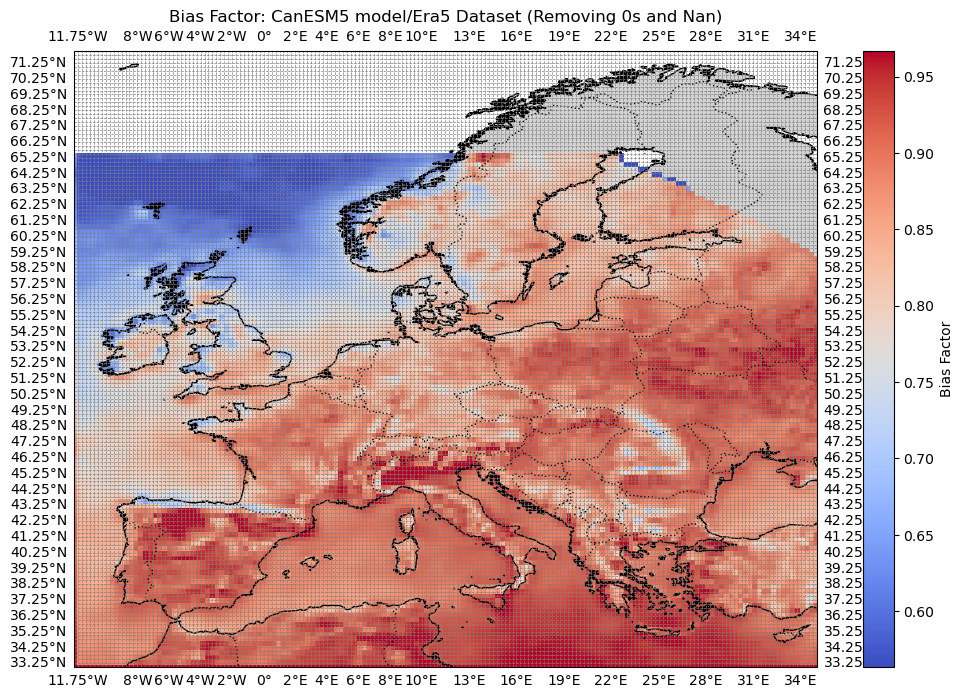

In [8]:
# Check if the biased_values shape matches lon2d, lat2d
# Get lat/lon values
lon = rsds_era5_mean_4y.lon.values 
lat = rsds_era5_mean_4y.lat.values

lon_era5=rsds_era5_mean_cut.lon.values
lat_era5=rsds_era5_mean_cut.lat.values

# Ensure lon/lat are 2D using meshgrid
# Ensure lon/lat are 2D using meshgrid
lon_edges = np.linspace(lon.min(), lon.max(), bias_factor_era5_sarah.shape[1] )
lat_edges = np.linspace(lat.min(), lat.max(), bias_factor_era5_sarah.shape[0] )
lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

# Use percentiles to remove outliers
vmin = np.nanpercentile(bias_factor_era5_sarah, 2)  # 2nd percentile (lower bound)
vmax = np.nanpercentile(bias_factor_era5_sarah, 98)  # 98th percentile (upper bound)

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()
print(f"Longitude range: {lon_min} to {lon_max}")
print(f"Latitude range: {lat_min} to {lat_max}")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Set the exact extent to match the dataset boundaries
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, bias_factor_era5_sarah,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto',
    vmin=vmin, vmax=vmax  # Clip extreme outliers
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Bias Factor: CanESM5 model/Era5 Dataset (Removing 0s and Nan)")

# Add gridlines for each latitude and longitude
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--', xlocs=lon, ylocs=lat, x_inline=False, y_inline=False)

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Bias Factor')

plt.show() 

In [5]:
numerator_era5_sarah.shape

(131, 157)

In [5]:
# Calculate the 2nd and 98th percentiles to exclude outliers
lower_percentile_bias_factor_era5_sarah = np.nanpercentile(bias_factor_era5_sarah, 2)  # 2nd percentile
upper_percentile_bias_factor_era5_sarah = np.nanpercentile(bias_factor_era5_sarah, 98)  # 98th percentile

# Print the percentiles to check their range
print(f"2nd Percentile: {lower_percentile_bias_factor_era5_sarah}")
print(f"98th Percentile: {upper_percentile_bias_factor_era5_sarah}")

# Mask the biased_values to keep only those within the 2nd and 98th percentiles
filtered_biased_values = bias_factor_era5_sarah[(bias_factor_era5_sarah >= lower_percentile_bias_factor_era5_sarah) & (bias_factor_era5_sarah <= upper_percentile_bias_factor_era5_sarah)]

# Calculate the mean of the filtered values
mean_bias_factor_era5_sarah = np.nanmean(filtered_biased_values)

print(f"Mean Bias Factor (excluding outliers): {mean_bias_factor_era5_sarah:.3f}")

2nd Percentile: 0.5633731484413147
98th Percentile: 0.9668134450912476
Mean Bias Factor (excluding outliers): 0.842


In [6]:
def fill_nans_with_last_valid(bias_factor):
    for lon in range(bias_factor.shape[1]):  # Iterate over longitudes (second axis)
        valid_values = ~np.isnan(bias_factor[:, lon])  # Find valid (non-NaN) indices along latitude
        if np.any(valid_values):  # If there's at least one valid value
            last_valid_idx = np.max(np.where(valid_values))  # Get the last valid latitude index
            bias_factor[last_valid_idx+1:, lon] = bias_factor[last_valid_idx, lon]  # Fill NaNs downward
    
    return bias_factor

# Apply the function to bias_factor_era5_sarah
bias_factor_era5_sarah = fill_nans_with_last_valid(bias_factor_era5_sarah)
bias_factor_era5_sarah


array([[1.0454338 , 0.96262056, 0.96645945, ..., 0.9977398 , 0.99822104,
        1.0055963 ],
       [0.95644873, 0.8792847 , 0.8825338 , ..., 0.91174465, 0.911982  ,
        0.9159733 ],
       [0.95877975, 0.8793321 , 0.8834796 , ..., 0.90792257, 0.910746  ,
        0.91893435],
       ...,
       [0.6452429 , 0.5743521 , 0.5633036 , ..., 0.88882524, 0.8909934 ,
        0.8961709 ],
       [0.6452429 , 0.5743521 , 0.5633036 , ..., 0.88882524, 0.8909934 ,
        0.8961709 ],
       [0.6452429 , 0.5743521 , 0.5633036 , ..., 0.88882524, 0.8909934 ,
        0.8961709 ]], dtype=float32)

In [10]:
import numpy as np

# Set the print options to display all elements in the array
np.set_printoptions(threshold=np.inf)  # This disables the truncation

# Print the entire array
print(bias_factor_era5_sarah)  # or your array name (e.g., bias_factor_era5_sarah)

# Reset back to default settings (optional)
# np.set_printoptions(threshold=1000)  # Set a threshold for a limited number of elements


[[1.0454338  0.96262056 0.96645945 0.9710242  0.97109854 0.96884614
  0.9630918  0.9635901  0.96648854 0.9683417  0.9767258  1.0168437
  1.0225245  1.0304532  1.0178444  1.013487   1.0104792  1.0148916
  1.0117042  1.0107177  1.0094755  1.0060769  0.9810311  1.0392461
  1.0772085  1.0564007  1.0420964  1.0248424  1.0165021  1.0005238
  0.9968769  0.9973782  0.98985016 0.98978233 0.9965313  0.993535
  0.9879957  0.98182595 0.970922   0.98488927 0.991234   0.9968016
  1.0030429  1.0145514  1.0144845  1.0163007  1.0191814  1.021029
  1.023724   1.0282145  1.027816   1.0324172  1.0348643  1.0327897
  1.0327672  1.0340497  1.0376371  1.031555   1.0264491  1.000846
  0.9928677  1.0170673  1.0248585  1.0315571  1.033407   1.0285354
  1.0281893  1.0305823  1.0316598  1.0320195  1.0427027  1.0468823
  1.0559446  1.0762618  1.0808554  1.0695735  1.0654584  1.0667356
  1.0514663  1.0341202  1.0157187  1.02138    1.0287191  1.0297723
  1.0313593  1.0388275  1.0440912  1.0467484  1.0490643  1.04687

In [7]:
from regridding_functions import read_and_average_era5_3h
from regridding_functions import read_and_average_cmip
rsds_era5_mean_BOC= read_and_average_era5_3h('influx_direct') #mean of era5 historical period for each grid cell
rsds_model_mean_BOC= read_and_average_cmip('SFCRAD/CanESM5/historical/r1i1p2f1/', 'rsds') #mean of model of historical period for each grid cell

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


['/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1980.nc', '/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1981.nc', '/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1982.nc', '/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1983.nc', '/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1984.nc', '/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1985.nc', '/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1986.nc', '/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1987.nc', '/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1988.nc', '/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1989.nc', '/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1990.nc', '/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1991.nc', '/g

In [8]:
rsds_era5_mean_BOC=rsds_era5_mean_BOC.sel(x=slice(-12, 35), y=slice(33, 72))
rsds_model_mean_BOC=rsds_model_mean_BOC.sel(lon=slice(-12, 35), lat=slice(33, 72))

In [9]:
ds_03=xr.open_dataset('europe_03.nc') #grid 0.3x0.3 

In [10]:
from regridding_functions import regrid
regridder_era5=regrid(rsds_era5_mean_BOC, ds_03, method='conservative') #regrid era5 to the 0.3x0.3º grid to be able to apply bias factor from sarah to era5
rsds_era5_03=regridder_era5(rsds_era5_mean_BOC) #regridded historical mean from era5 to 0.3x0.3º grid
rsds_era5_03.sel(lon=slice(-12, 35), lat=slice(33, 72))
#bias_factor_era5_sarah.shape
rsds_era5_03
rsds_era5_correct=rsds_era5_03.sel(lon=slice(-12, 35), lat=slice(33, 72))*bias_factor_era5_sarah #apply bias factor to era5 rsds
rsds_era5_correct #era5 corrected with srah/era5 bias factor, historical mean in 0.3x0.3º grid

189 190
157 158
157 158
131 132


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_direct as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.DataArray (lat: 131, lon: 157)> Size: 82kB
dask.array<mul, shape=(131, 157), dtype=float32, chunksize=(131, 157), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB 33.0 33.3 33.6 33.9 34.2 ... 71.1 71.4 71.7 72.0
  * lon      (lon) float64 1kB -12.0 -11.7 -11.4 -11.1 ... 33.9 34.2 34.5 34.8

In [11]:
regridder_era503_model=regrid(rsds_era5_correct, rsds_model_mean_BOC, method='conservative') #regrid corrected era5 to the model grid, conservative method because upscaling
rsds_era5_correct_model=regridder_era503_model(rsds_era5_correct) #regrid corrected era5 to the model grid
rsds_era5_correct_model=rsds_era5_correct_model.sel(lon=slice(-12, 35), lat=slice(33, 72))
#rsds_era5_correct_model is the corrected era5 dataset in the model grid
rsds_era5_correct_model

157 158
131 132
17 18
14 15


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable None as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.DataArray (lat: 14, lon: 17)> Size: 952B
dask.array<astype, shape=(14, 17), dtype=float32, chunksize=(14, 17), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 56B 34.88 37.67 40.46 43.25 ... 65.58 68.37 71.16
  * lon      (lon) float32 68B -11.25 -8.438 -5.625 -2.812 ... 28.12 30.94 33.75
Attributes:
    regrid_method:  conservative

In [12]:
def check_lat_lon_range_and_increment(ds, dataset_name):
    # Extract the latitude and longitude
    lat = ds.lat
    lon = ds.lon
    
    # Latitude and longitude range
    lat_range = (lat.min().values, lat.max().values)
    lon_range = (lon.min().values, lon.max().values)
    
    # Latitude and longitude increment (difference between consecutive values)
    lat_increment = np.abs(lat[1] - lat[0]).values
    lon_increment = np.abs(lon[1] - lon[0]).values
    
    print(f"Dataset: {dataset_name}")
    print(f"Latitude range: {lat_range}")
    print(f"Longitude range: {lon_range}")
    print(f"Latitude increment: {lat_increment} degrees")
    print(f"Longitude increment: {lon_increment} degrees")
    print("-" * 50)

# Check for rsds_era5_mean_cut
check_lat_lon_range_and_increment(rsds_era5_correct_model, "rsds_era5_correct model")

# Check for rsds_era5_mean_interp_cut
check_lat_lon_range_and_increment(rsds_model_mean_BOC, "rsds_model_mean_interp_cut")
check_lat_lon_range_and_increment(rsds_era5_03, "rsds_era5_0.3x0.3")

Dataset: rsds_era5_correct model
Latitude range: (array(34.88252258), array(71.15775299))
Longitude range: (array(-11.25), array(33.75))
Latitude increment: 2.7905654907226562 degrees
Longitude increment: 2.8125 degrees
--------------------------------------------------
Dataset: rsds_model_mean_interp_cut
Latitude range: (array(34.88252258), array(71.15775299))
Longitude range: (array(-11.25), array(33.75))
Latitude increment: 2.7905654907226562 degrees
Longitude increment: 2.8125 degrees
--------------------------------------------------
Dataset: rsds_era5_0.3x0.3
Latitude range: (array(33.), array(72.))
Longitude range: (array(-12.), array(34.8))
Latitude increment: 0.29999999999999716 degrees
Longitude increment: 0.3000000000000007 degrees
--------------------------------------------------


In [13]:
numerator_era5_model=rsds_era5_correct_model.values
denominator_era5_model=rsds_model_mean_BOC.values
# Ensure valid bias factor calculation
mask_valid_2 = (denominator_era5_model != 0) & (numerator_era5_model != 0)  # Avoid values 0 
bias_factor_era5_model = np.where(mask_valid_2, numerator_era5_model / denominator_era5_model, np.nan)  # Replace invalid cases with NaN
bias_factor_era5_model
bias_factor_era5_model.shape

(14, 17)

In [14]:
print(bias_factor_era5_model.mean())

0.47190782


In [19]:
rsds_model_mean_BOC.shape 

(14, 17)

In [20]:
#corrected means of model BoC
rsds_model_correct=rsds_model_mean_BOC*bias_factor_era5_model
rsds_model_correct

<xarray.DataArray 'rsds' (lat: 14, lon: 17)> Size: 952B
dask.array<mul, shape=(14, 17), dtype=float32, chunksize=(14, 17), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 68B -11.25 -8.438 -5.625 -2.812 ... 28.12 30.94 33.75
  * lat      (lat) float32 56B 34.88 37.67 40.46 43.25 ... 65.58 68.37 71.16

In [21]:
#calculating means of model EoC, 2070-2100
from regridding_functions import read_and_average_cmip_EOC_end
rsds_model_mean_EOC= read_and_average_cmip_EOC_end('SFCRAD/CanESM5/ssp585/r1i1p2f1/', 'rsds') #mean of model of historical period for each grid cell

['/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2070.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2071.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2072.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2073.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2074.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2075.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2076.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2077.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2078.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2079.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2080.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/rsds_rsdsdiff_tas_2081.nc', '/groups/FutureWind/SFCRAD/CanESM5/ssp585/r1i1p2f1/

In [22]:
rsds_model_mean_EOC=rsds_model_mean_EOC.sel(lon=slice(-12, 35), lat=slice(33, 72))
rsds_model_mean_EOC.shape

(14, 17)

In [23]:
rsds_model_mean_BOC.lat.values 

array([34.882523, 37.673088, 40.46365 , 43.254196, 46.044727, 48.83524 ,
       51.625732, 54.4162  , 57.20663 , 59.99702 , 62.787354, 65.57761 ,
       68.36776 , 71.15775 ], dtype=float32)

Longitude range: -11.25 to 33.75
Latitude range: 34.88252258300781 to 71.15775299072266


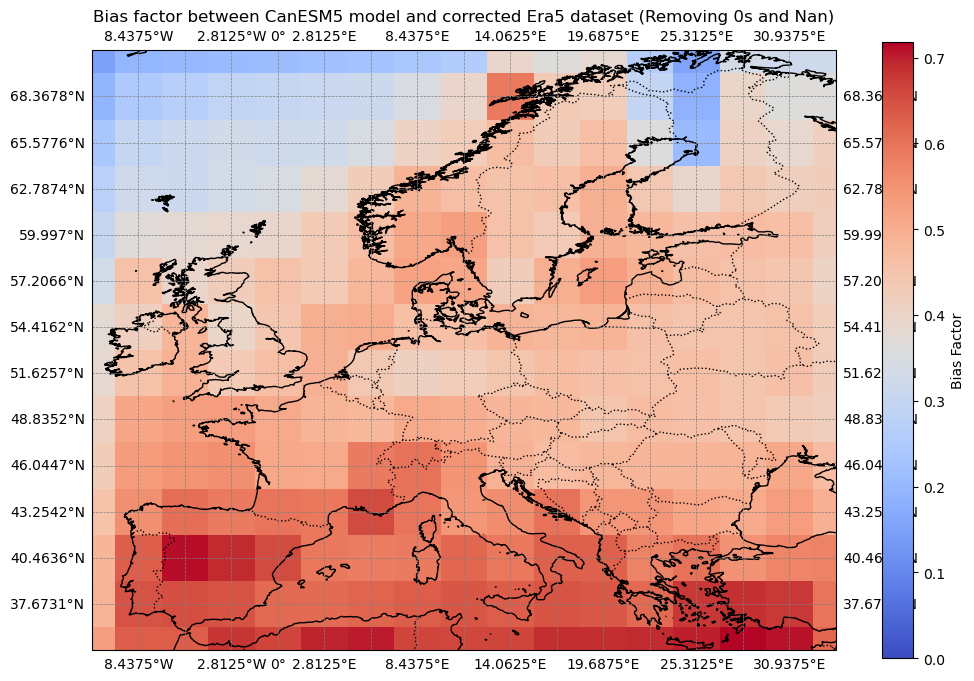

In [25]:
#comparison between model BoC without and with the bias factor
# Check if the biased_values shape matches lon2d, lat2d
# Get lat/lon values
lon = rsds_model_mean_BOC.lon.values 
lat = rsds_model_mean_BOC.lat.values


# Ensure lon/lat are 2D using meshgrid
# Ensure lon/lat are 2D using meshgrid
lon_edges = np.linspace(lon.min(), lon.max(), rsds_model_mean_EOC.shape[1] )
lat_edges = np.linspace(lat.min(), lat.max(), rsds_model_mean_EOC.shape[0] )
lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()
print(f"Longitude range: {lon_min} to {lon_max}")
print(f"Latitude range: {lat_min} to {lat_max}")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Set the exact extent to match the dataset boundaries
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, bias_factor_era5_model,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto', # Clip extreme outliers
    vmin=0
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Bias factor between CanESM5 model and corrected Era5 dataset (Removing 0s and Nan)")

# Add gridlines for each latitude and longitude
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--', xlocs=lon, ylocs=lat, x_inline=False, y_inline=False)

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Bias Factor')

plt.show() 

In [26]:
bias_factor_era5_model_mean=bias_factor_era5_model.mean()
print(bias_factor_era5_model_mean)

0.47191244


In [24]:
rsds_model_mean_EOC_correct=rsds_model_mean_EOC*bias_factor_era5_model

Longitude range: -11.25 to 33.75
Latitude range: 34.88252258300781 to 71.15775299072266


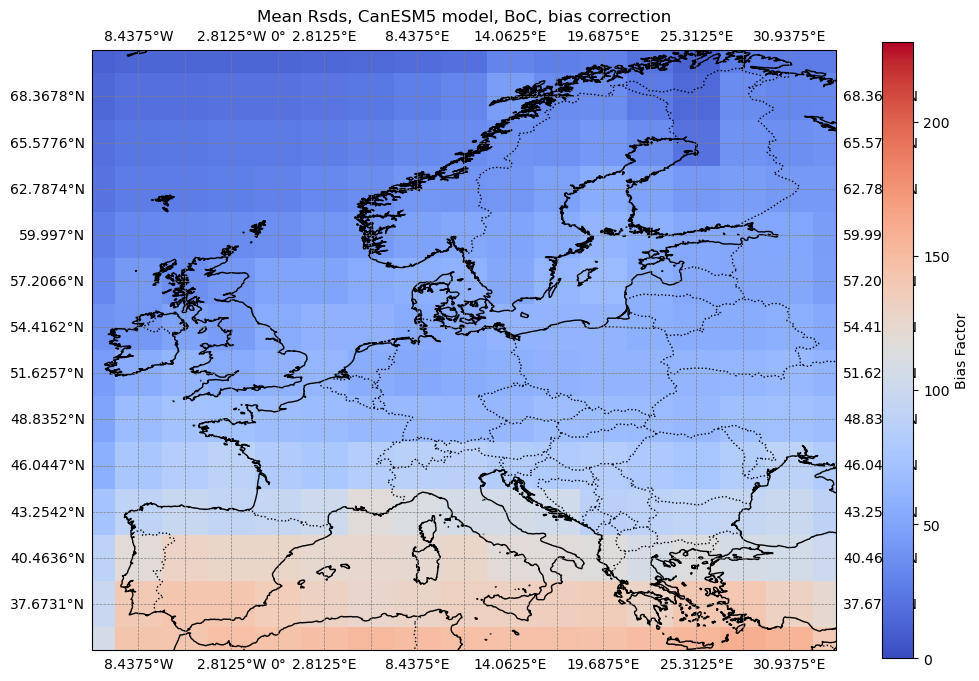

In [27]:
#comparison between model BoC without and with the bias factor
# Check if the biased_values shape matches lon2d, lat2d
# Get lat/lon values
lon = rsds_model_mean_BOC.lon.values 
lat = rsds_model_mean_BOC.lat.values


# Ensure lon/lat are 2D using meshgrid
# Ensure lon/lat are 2D using meshgrid
lon_edges = np.linspace(lon.min(), lon.max(), rsds_model_mean_EOC_correct.shape[1] )
lat_edges = np.linspace(lat.min(), lat.max(), rsds_model_mean_EOC_correct.shape[0] )
lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()
print(f"Longitude range: {lon_min} to {lon_max}")
print(f"Latitude range: {lat_min} to {lat_max}")
vmin=rsds_model_mean_EOC.min().values
vmax=rsds_model_mean_EOC.max().values
# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Set the exact extent to match the dataset boundaries
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, rsds_model_correct,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto', # Clip extreme outliers
    vmin=0, vmax=vmax
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Mean Rsds, CanESM5 model, BoC, bias correction")

# Add gridlines for each latitude and longitude
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--', xlocs=lon, ylocs=lat, x_inline=False, y_inline=False)

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Bias Factor')

plt.show() 

In [28]:
difference_EOC_BOC=rsds_model_mean_EOC_correct-rsds_model_correct
relative_difference_EOC_BOC=difference_EOC_BOC/rsds_model_correct*100

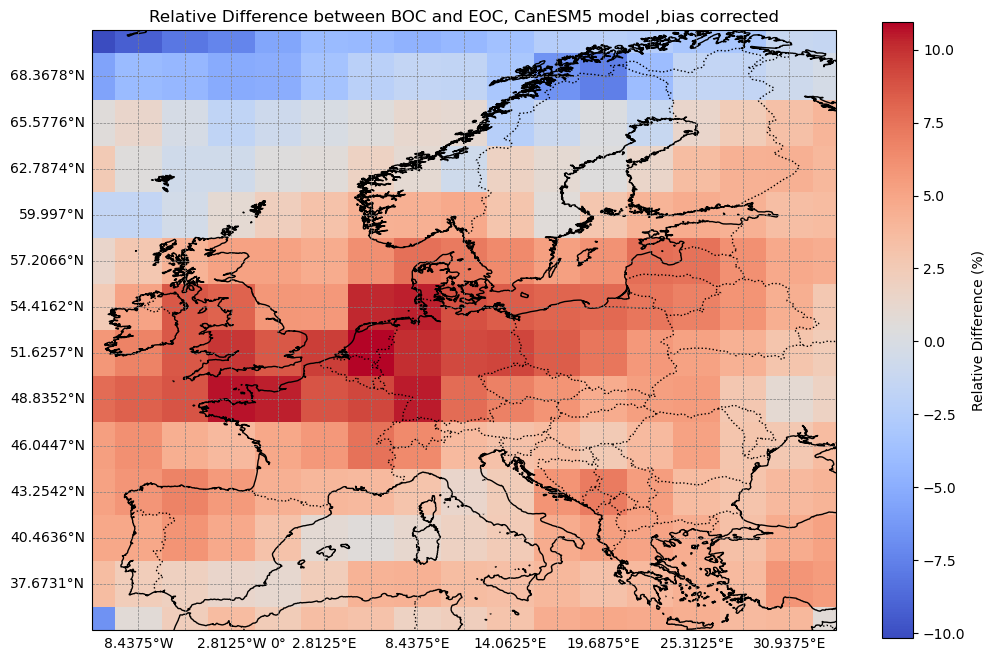

In [29]:
# Get lat/lon values
lon = rsds_model_correct.lon.values 
lat = rsds_model_correct.lat.values

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()


# Ensure lon/lat are 2D using meshgrid
# Ensure lon/lat are 2D using meshgrid
lon_edges = np.linspace(lon.min(), lon.max(), rsds_model_correct.shape[1] )
lat_edges = np.linspace(lat.min(), lat.max(), rsds_model_correct.shape[0] )
lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Set the exact extent to match the dataset boundaries
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, relative_difference_EOC_BOC,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto'  
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Relative Difference between BOC and EOC, CanESM5 model ,bias corrected")

# Add gridlines for each latitude and longitude
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    xlocs=rsds_model_correct.lon, 
    ylocs=rsds_model_correct.lat, 
    x_inline=False, 
    y_inline=False
)

# Configure gridline labels
gridlines.right_labels = False  # Disable latitude labels on the right
gridlines.left_labels = True    # Enable latitude labels on the left
gridlines.top_labels = False    # Disable longitude labels on the top
gridlines.bottom_labels = True  # Enable longitude labels on the bottom
# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Relative Difference (%)')

plt.show() 

In [30]:
rsdsdiff_era5_mean_4y= read_and_average_era5_4y('influx_diffuse') #read and av the 4 years of era5 for bias correction with sarah
rsdsdiff_sarah_mean= read_and_average_sarah('influx_diffuse') #same for sarah
rsdsdiff_era5_mean_cut=rsdsdiff_era5_mean_4y.sel(x=slice(-12, 35), y=slice(33, 72)) #cut to the max latitude covered by sarah
rsdsdiff_sarah_mean_cut=rsdsdiff_sarah_mean.sel(x=slice(-12, 35), y=slice(33, 72))
regridder_rsdsdiff=regrid(rsdsdiff_era5_mean_cut, rsdsdiff_sarah_mean_cut, method='conservative')  #regrid era5 (0.25x0.25) to the sarah grid (0.3x0.3)

['/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc', '/groups/EXTREMES/cutouts/europe-2012-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc']
['/groups/EXTREMES/SARAH-3/europe-1996-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2012-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc']
189 190
157 158
157 158
131 132


In [36]:
rsdsdiff_era5_mean_interp_cut_4y=regridder_rsdsdiff(rsdsdiff_era5_mean_cut)
# Assuming these variables exist
denominator_era5_sarah_rsdsdiff= rsdsdiff_era5_mean_interp_cut_4y.values  # ERA5 dataset
numerator_era5_sarah_rsdsdiff= rsdsdiff_sarah_mean_cut.values  # SARAH dataset

# Ensure valid bias factor calculation
mask_valid_rsdsdiff = (denominator_era5_sarah_rsdsdiff != 0) & (numerator_era5_sarah_rsdsdiff != 0) # Avoid division by zero and all values in sarah that have mean 0
bias_factor_era5_sarah_rsdsdiff = np.where(mask_valid, numerator_era5_sarah_rsdsdiff / denominator_era5_sarah_rsdsdiff, np.nan)

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_diffuse as the horizontal dimensions for the regridding.
  warnings.warn(


In [37]:
# Apply the function to bias_factor_era5_sarah
bias_factor_era5_sarah_rsdsdiff = fill_nans_with_last_valid(bias_factor_era5_sarah_rsdsdiff)
bias_factor_era5_sarah_rsdsdiff

array([[1.4477327 , 1.327159  , 1.3228549 , 1.3245041 , 1.3305535 ,
        1.3367332 , 1.3457625 , 1.3468544 , 1.3494575 , 1.3591765 ,
        1.3728704 , 1.3744708 , 1.3752971 , 1.3634933 , 1.3885747 ,
        1.4052942 , 1.4121915 , 1.4040551 , 1.4018732 , 1.3849317 ,
        1.3613281 , 1.3286406 , 1.2890004 , 1.2701603 , 1.219929  ,
        1.2223482 , 1.2437547 , 1.2582612 , 1.2939054 , 1.3223034 ,
        1.3414419 , 1.35029   , 1.3632269 , 1.3668545 , 1.3511292 ,
        1.338371  , 1.3385453 , 1.3401775 , 1.3408015 , 1.3306521 ,
        1.3255957 , 1.3295989 , 1.3226041 , 1.310673  , 1.3098583 ,
        1.313658  , 1.3167355 , 1.3255024 , 1.3281732 , 1.3240994 ,
        1.3242025 , 1.3203062 , 1.3201857 , 1.3284303 , 1.3283656 ,
        1.3257382 , 1.3266268 , 1.3364633 , 1.3389966 , 1.3669226 ,
        1.3854891 , 1.3548787 , 1.3410554 , 1.3376945 , 1.3350252 ,
        1.333266  , 1.3294134 , 1.3262811 , 1.3242217 , 1.3256363 ,
        1.3146715 , 1.3072261 , 1.3027717 , 1.29

In [ ]:
rsdsdiff_era5_mean_BOC= read_and_average_era5_3h('influx_diffuse') #mean of era5 historical period for each grid cell
rsdsdiff_model_mean_BOC= read_and_average_cmip('SFCRAD/CanESM5/historical/r1i1p2f1/', 'rsdsdiff') #mean of model of historical period for each grid cell

['/groups/EXTREMES/cutouts/europe-1980-era5.nc', '/groups/EXTREMES/cutouts/europe-1981-era5.nc', '/groups/EXTREMES/cutouts/europe-1982-era5.nc', '/groups/EXTREMES/cutouts/europe-1983-era5.nc', '/groups/EXTREMES/cutouts/europe-1984-era5.nc', '/groups/EXTREMES/cutouts/europe-1985-era5.nc', '/groups/EXTREMES/cutouts/europe-1986-era5.nc', '/groups/EXTREMES/cutouts/europe-1987-era5.nc', '/groups/EXTREMES/cutouts/europe-1988-era5.nc', '/groups/EXTREMES/cutouts/europe-1989-era5.nc', '/groups/EXTREMES/cutouts/europe-1990-era5.nc', '/groups/EXTREMES/cutouts/europe-1991-era5.nc', '/groups/EXTREMES/cutouts/europe-1992-era5.nc', '/groups/EXTREMES/cutouts/europe-1993-era5.nc', '/groups/EXTREMES/cutouts/europe-1994-era5.nc', '/groups/EXTREMES/cutouts/europe-1995-era5.nc', '/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-1997-era5.nc', '/groups/EXTREMES/cutouts/europe-1998-era5.nc', '/groups/EXTREMES/cutouts/europe-1999-era5.nc', '/groups/EXTREMES/cutouts/europe-2000-e

In [39]:
rsdsdiff_era5_mean_BOC=rsdsdiff_era5_mean_BOC.sel(x=slice(-12, 35), y=slice(33, 72))
rsdsdiff_model_mean_BOC=rsdsdiff_model_mean_BOC.sel(lon=slice(-12, 35), lat=slice(33, 72))

In [40]:
regridder_era5_rsdsdiff=regrid(rsdsdiff_era5_mean_BOC, ds_03, method='conservative') #regrid era5 to the 0.3x0.3º grid to be able to apply bias factor from sarah to era5
rsdsdiff_era5_03=regridder_era5(rsdsdiff_era5_mean_BOC) #regridded historical mean from era5 to 0.3x0.3º grid
rsdsdiff_era5_03.sel(lon=slice(-12, 35), lat=slice(33, 72))
#bias_factor_era5_sarah.shape
rsdsdiff_era5_03
rsdsdiff_era5_correct=rsds_era5_03.sel(lon=slice(-12, 35), lat=slice(33, 72))*bias_factor_era5_sarah #apply bias factor to era5 rsds
rsdsdiff_era5_correct #era5 corrected with srah/era5 bias factor, historical mean in 0.3x0.3º grid
regridder_era503_model_rsdsdiff=regrid(rsdsdiff_era5_correct, rsdsdiff_model_mean_BOC, method='conservative') #regrid corrected era5 to the model grid, conservative method because upscaling
rsdsdiff_era5_correct_model=regridder_era503_model_rsdsdiff(rsdsdiff_era5_correct) #regrid corrected era5 to the model grid
rsdsdiff_era5_correct_model=rsdsdiff_era5_correct_model.sel(lon=slice(-12, 35), lat=slice(33, 72))
numerator_era5_model_rsdsdiff=rsdsdiff_era5_correct_model.values
denominator_era5_model_rsdsdiff=rsdsdiff_model_mean_BOC.values
# Ensure valid bias factor calculation
mask_valid_3 = (denominator_era5_model_rsdsdiff != 0) & (numerator_era5_model_rsdsdiff != 0)  # Avoid values 0 
bias_factor_era5_model_rsdsdiff = np.where(mask_valid_2, numerator_era5_model_rsdsdiff / denominator_era5_model_rsdsdiff, np.nan)  # Replace invalid cases with NaN
bias_factor_era5_model_rsdsdiff

189 190
157 158
157 158
131 132


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_diffuse as the horizontal dimensions for the regridding.
  warnings.warn(


157 158
131 132
17 18
14 15


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable None as the horizontal dimensions for the regridding.
  warnings.warn(


array([[1.2398995 , 2.034801  , 2.0149348 , 1.9903609 , 1.89888   ,
        1.8375549 , 1.8306674 , 1.884293  , 1.9708532 , 1.926219  ,
        1.8351988 , 1.8199058 , 1.94201   , 2.0607104 , 2.1958408 ,
        2.130702  , 1.9590315 ],
       [1.2966402 , 2.0646293 , 2.0976434 , 2.106326  , 2.0345206 ,
        1.8714938 , 1.7335325 , 1.7381358 , 1.8002177 , 1.778769  ,
        1.8048081 , 1.8504573 , 1.7745624 , 1.9815091 , 2.0306127 ,
        1.8043308 , 1.670758  ],
       [1.1826344 , 1.6995777 , 1.809522  , 1.6795028 , 1.742653  ,
        1.8346298 , 1.9156731 , 1.8609593 , 1.9079684 , 1.7323436 ,
        1.6663901 , 1.5997735 , 1.4731878 , 1.6266342 , 1.5540171 ,
        1.5125767 , 1.3598348 ],
       [0.91329914, 1.2108854 , 1.3223963 , 1.2588301 , 1.31623   ,
        1.4356927 , 1.7248619 , 1.6908048 , 1.6466079 , 1.6439184 ,
        1.5185263 , 1.199736  , 1.1701533 , 1.2367997 , 1.3688712 ,
        1.462438  , 1.3319396 ],
       [0.6840843 , 0.9398422 , 1.0811697 , 1.239726

In [41]:
bias_factor_era5_model_rsdsdiff

array([[1.2398995 , 2.034801  , 2.0149348 , 1.9903609 , 1.89888   ,
        1.8375549 , 1.8306674 , 1.884293  , 1.9708532 , 1.926219  ,
        1.8351988 , 1.8199058 , 1.94201   , 2.0607104 , 2.1958408 ,
        2.130702  , 1.9590315 ],
       [1.2966402 , 2.0646293 , 2.0976434 , 2.106326  , 2.0345206 ,
        1.8714938 , 1.7335325 , 1.7381358 , 1.8002177 , 1.778769  ,
        1.8048081 , 1.8504573 , 1.7745624 , 1.9815091 , 2.0306127 ,
        1.8043308 , 1.670758  ],
       [1.1826344 , 1.6995777 , 1.809522  , 1.6795028 , 1.742653  ,
        1.8346298 , 1.9156731 , 1.8609593 , 1.9079684 , 1.7323436 ,
        1.6663901 , 1.5997735 , 1.4731878 , 1.6266342 , 1.5540171 ,
        1.5125767 , 1.3598348 ],
       [0.91329914, 1.2108854 , 1.3223963 , 1.2588301 , 1.31623   ,
        1.4356927 , 1.7248619 , 1.6908048 , 1.6466079 , 1.6439184 ,
        1.5185263 , 1.199736  , 1.1701533 , 1.2367997 , 1.3688712 ,
        1.462438  , 1.3319396 ],
       [0.6840843 , 0.9398422 , 1.0811697 , 1.239726

In [42]:
bias_factor_era5_model

array([[0.5286069 , 0.6328238 , 0.6325103 , 0.6806467 , 0.66382724,
        0.6975879 , 0.7036784 , 0.6642929 , 0.66004974, 0.66358703,
        0.68799216, 0.6898864 , 0.69167686, 0.70085627, 0.7179532 ,
        0.7080341 , 0.6183454 ],
       [0.48726144, 0.6475124 , 0.6522719 , 0.64355814, 0.6163449 ,
        0.61262405, 0.6224063 , 0.6336406 , 0.6408341 , 0.63293964,
        0.6431207 , 0.63795066, 0.61432534, 0.67833614, 0.6855495 ,
        0.6780861 , 0.60010785],
       [0.48294413, 0.6304028 , 0.7100313 , 0.6919876 , 0.6553904 ,
        0.5933405 , 0.5856422 , 0.5878989 , 0.6181292 , 0.59361243,
        0.6279867 , 0.6254515 , 0.57544345, 0.60145825, 0.55003905,
        0.574776  , 0.5772613 ],
       [0.45203418, 0.5578146 , 0.60670656, 0.5862558 , 0.59788096,
        0.5938167 , 0.6557378 , 0.5985486 , 0.54276574, 0.55901283,
        0.6024141 , 0.545175  , 0.54407763, 0.5166715 , 0.507515  ,
        0.5312265 , 0.4953173 ],
       [0.42639863, 0.5340843 , 0.54949397, 0.557963